# Agent to take follow up actions after analysis issue fix

This is an agent that uses "Additional Information" from fix generation agent to make further changes.

For faster prototyping, we use LangGraph for implementing this.

We create a simple network of agents - FixGenerationAgent, FileOperationsAgent. 

The _FixGenerationAgent_ is the same as what we use today to fix analyzer issues. _FileOperationsAgent_ is a new agent we introduce that takes follow up actions. The follow up actions include updating another file, removing a file, or creating a new file. For each operation, we have a tool defined.

![Diagram](./screenshots/Tool.png)

# Fix Generation Agent

This is same as the existing agent we use to fix analysis issues.

We are using a few hardcoded examples of analysis issues to generate fixes.

Before proceeding, make sure you are using Kai venv to run cells in this notebook.

We need to install `langgraph` module, run following cell:

In [ ]:
%load_ext dotenv
%dotenv
%pip install langgraph

In [72]:
# THIS CELL CONTAINS SOME COMMON FUNCTIONS WE WILL USE, RUN THIS CELL BEFORE MOVING FORWARD

import re

def parse_llm_response(message: str) -> tuple[str, str, str]:
    lines_of_output = message.splitlines()
    in_source_file = False
    in_reasoning = False
    in_additional_details = False
    source_file = ""
    reasoning = ""
    additional_details = ""
    for line in lines_of_output:
        # trunk-ignore(cspell/error)
        if re.match(r"(?:##|\*\*)\s+[Rr]easoning", line.strip()):
            in_reasoning = True
            in_source_file = False
            in_additional_details = False
            continue
        # trunk-ignore(cspell/error)
        if re.match(r"(?:##|\*\*)\s+[Uu]pdated.*[Ff]ile", line.strip()):
            in_source_file = True
            in_reasoning = False
            in_additional_details = False
            continue
        # trunk-ignore(cspell/error)
        if re.match(r"(?:##|\*\*)\s+[Aa]dditional\s+[Ii]nformation", line.strip()):
            in_reasoning = False
            in_source_file = False
            in_additional_details = True
            continue
        if in_source_file:
            if re.match(r"```(?:\w*)", line):
                continue
            source_file = "\n".join([source_file, line])
        if in_reasoning:
            reasoning = "\n".join([reasoning, line])
        if in_additional_details:
            additional_details = "\n".join([additional_details, line])
    return source_file, reasoning, additional_details

We will create the analysis fix agent and generate a few example fixes to be used with file operation agents. 

The example issues are taken from Coolstore application analysis and can be found in [example_prompts](./example_prompts/) directory.

Running the following cell will generate analysis fixes for all examples and store them in variables for later use.

In [73]:
from pathlib import Path
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

# fix generation agent
fix_gen_agent = create_react_agent(
    model=llm,
    name="fix_gen_agent",
    prompt="You are an experienced Java developer, who specializes in migrating code from Java EE to Quarkus",
    tools=[],
)

raw_response_ex1 = fix_gen_agent.invoke({
    "messages": [
        HumanMessage(content=Path("example_prompts", "inventory_notification_java", "jms-to-reactive-quarkus-00050").read_text()),
    ]
})

In [4]:
_, _, additional_info_ex1 = parse_llm_response(raw_response_ex1["messages"][-1].content)
print("We will use following additional info for Example-1:")
print(additional_info_ex1)

We will use following additional info for Example-1:


- Ensure your `pom.xml` includes the necessary Quarkus SmallRye Reactive Messaging dependencies. For example:
  ```xml
  <dependency>
    <groupId>io.quarkus</groupId>
    <artifactId>quarkus-smallrye-reactive-messaging</artifactId>
  </dependency>
  ```
- Configure the messaging channel in `application.properties` to connect to your message broker.
- This refactor assumes that somewhere in the application's configuration, the channel with the name `"orders"` is set up.
- Further migration steps might include migrating other Java EE specific annotations and configurations to their Quarkus equivalents.


## File Operations Agent

This is the agent that will take "Additional Information" generated by previous agent as input and take actions if there is anything important in additional information. 

The actions include:
 * updating an existing file (which may not be same as the original file we fixed)
 * deleting a file
 * creating a new file

The agent will use following tools to take the above options:
 * find: Finds relevant files in the project
 * read: Reads a file in the project
 * write: Writes content to a file in the project
 * rm: Removes a file from the project

In the following cell, we define these tools and the agent.

The [project](./project/) directory is the base of the project and will be used by the agent to perform file operations.

In [74]:
import os
import glob
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing import Annotated

@tool
def find(file_name_pattern: Annotated[str, "Glob pattern to match file names"]) -> Annotated[str, "Absolute paths of the files found separated by newlines"]:
    """Given a glob pattern, searches for files matching the pattern in project and returns absolute paths of the files

    Returns:
        str: Newline separated list of filepaths
    """
    try:
        matching_files = glob.glob("./project/" + file_name_pattern, recursive=True)
    except Exception as e:
        return f"Failed to search for files because of error - {e}"
    absolute_paths = [os.path.abspath(file) for file in matching_files]
    if not absolute_paths:
        return f"No files found matching pattern {file_name_pattern}"
    return "\n".join(absolute_paths)

@tool
def read(file_name: Annotated[str, "Absolute path to the file to read"]):
    """Given an absolute path to a file, reads the file and returns content"""
    if os.path.exists(file_name):
        contents = ""
        with open(file_name, "r") as f:
            contents = f.read()
        return f"Here are the file contents:\n```{contents}```"
    return f"File {file_name} does not exist"

@tool
def write(file_name: Annotated[str, "Absolute path to the file"], content: Annotated[str, "Content to write to the file"]):
    """Given an absolute path to a file and the content, writes content to the file. If the file doesn't exist, creates a new file.
    If the directories dont exist, creates all parent directories."""
    try:
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name, "w+") as f:
            f.write(content)
        return f"Successfully wrote contents to file {file_name}"
    except Exception as e:
        return f"Failed to write to file with error {e}"

@tool
def rm(file: Annotated[str, "Full path of the file to remove"]):
    """Removes file"""
    if os.path.exists(file):
        os.remove(file)
        return "Removed the file"
    return f"File {file} does not exist"

file_ops_agent = create_react_agent(
    model=llm,
    tools=[find, read, write, rm],
    prompt="""You are an expert Java developer. You are asked to make changes in a Java project.
You can either update an existing file, delete a file, or create a new file with relevant content.
To update or delete an existing file, search for the file to update using a glob pattern, and determine which file to update from the files found.
To update an existing file, make sure you read the file to get existing contents, and then write to the file updated content.
If a file doesn't exist and needs to be created, create that file.
Always use absolute file paths to make changes to files. You are given tools to perform file operations. Use the tools, and make the changes needed.
Use your best judgement to solve the issues described.
""",
)

for state in file_ops_agent.stream(
    {"messages": [HumanMessage(content=additional_info_ex1)]},
    stream_mode=["updates"]
):
    print(state)

('updates', {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r97mhoOlCxYtNBlJvj4FzFyH', 'function': {'arguments': '{"file_name_pattern":"**/pom.xml"}', 'name': 'find'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 496, 'total_tokens': 515, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-be4a4137-0eca-4faf-80d0-c1df0f511572-0', tool_calls=[{'name': 'find', 'args': {'file_name_pattern': '**/pom.xml'}, 'id': 'call_r97mhoOlCxYtNBlJvj4FzFyH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 496, 'output_tokens': 19, 'total_tokens': 515, 'input_token_details': {'audio': 0, 'cache_read': 

## Results

In the above output, you can see that the model searched for `pom.xml` file and added the dependency. 

It also searched for `application.properties` file but it wasn't found, so it created a new file at path `src/main/resources` which is the correct path for Quarkus applications. 

This proves the possibility of updating another file from the project, AND creating a new file.

I have attached screenshots of the results from my environment below.

![pom_xml_update](./screenshots/pom_xml_update.png)

![application_properties_creation](./screenshots/application_properties_creation.png)

## File Removal Example

Lets take a look at another example where we have to remove a `web.xml` file. 

In [10]:
additional_info_ex2 = """- **Documentation Reference:** For more details on how Quarkus handles CDI, refer to the [Quarkus CDI Guide](https://quarkus.io/guides/cdi).
- **Testing:** After removing `beans.xml`, ensure that the application is tested to verify that CDI is functioning as expected without the file.
- **Dependencies:** Double-check the `pom.xml` to ensure all necessary CDI dependencies are included for Quarkus. This typically involves ensuring that the `quarkus-resteasy` or `quarkus-arc` extensions are present, as they provide CDI support."""

for state in file_ops_agent.stream(
    {"messages": [HumanMessage(content=additional_info_ex2)]},
    stream_mode=["updates"]
):
    print(state)

('updates', {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BErckULSix64WOTimSabFREt', 'function': {'arguments': '{"file_name_pattern":"**/beans.xml"}', 'name': 'find'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 486, 'total_tokens': 505, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e6e94688-0c50-4a39-b16d-ff9e3cb17734-0', tool_calls=[{'name': 'find', 'args': {'file_name_pattern': '**/beans.xml'}, 'id': 'call_BErckULSix64WOTimSabFREt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 486, 'output_tokens': 19, 'total_tokens': 505, 'input_token_details': {'audio': 0, 'cache_rea

## Results

We can see that the `beans.xml` file is removed by the agent. See screenshot below:

![beans_removal](./screenshots/beans_xml_removal.png)

## Validating tool usage with different providers via Model Provider

This section validates that we are able to use tools with different Model Providers we support.

In [75]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.language_models import LanguageModelLike

@tool
def get_temperature(city: Annotated[str, "Name of the city"]):
    """Returns current temperature in given city"""
    return f"Current temperature in {city} is 80 degrees."

def validate(model: LanguageModelLike, **kwargs):
    agent = create_react_agent(
        model=model,
        tools=[get_temperature],
        prompt="Help the user with their queries, use the tools at your disposal.",
        **kwargs,
    )

    for r in agent.stream({"messages": [("user", "What is the current temperature in New York?")]}):
        print(r)


Depending on which model you test this with, you need to set up your API keys for the model before running the "validation" cell. Every cell has a comment at top about the environment variable expected.

You will set the keys in `.env` file at the project root and run the following cell for changes to take effect.

### Results

|   Kai Model Provider   |      Model       |  Works?  |
| ---------------------- | ---------------- | -------- |
| ChatOpenAI             | gpt-3.5-turbo    |  &check; |
| ChatOpenAI (RH Maas)   | granite-8b       |  &check; |
| ChatOpenAI (RH Maas)   | llama-7b         |  &check; |
| ChatBedrock            | llama-70b-v1     |  &cross; |
| ChatBedrock            | llama-70b-v2     |  &cross; |
| ChatBedrock            | claude-3-sonnet  |  &check; |
| ChatGoogleGenAI        | gemini-2.0-flash |  &check; |
| ChatDeepSeek           | deepseek-chat    |  &check; |

Following model providers are not tested yet:

* ChatOllama
* ChatAzureOpenAI

In [67]:
%dotenv

In [ ]:
## Test with granite-8b on RH maas via ChatOpenAI
## Env vars needed:
## PARASOL_GRANITE_KEY - api key
## PARASON_GRANITE_API - base url (usually ends with /v1)

from kai.llm_interfacing.model_provider import ChatOpenAI

validate(ChatOpenAI(
    api_key=os.environ["PARASOL_GRANITE_KEY"],
    base_url=os.environ["PARASOL_GRANITE_API"],
    model_name="granite-3-8b-instruct",
))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-93d38e3ef7764368aeab44edfa14db42', 'function': {'arguments': '{"city": "New York"}', 'name': 'get_temperature'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 140, 'total_tokens': 165, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'granite-3-8b-instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-97df9c64-fad3-4df2-b314-76b4fc50324e-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': 'chatcmpl-tool-93d38e3ef7764368aeab44edfa14db42', 'type': 'tool_call'}], usage_metadata={'input_tokens': 140, 'output_tokens': 25, 'total_tokens': 165, 'input_token_details': {}, 'output_token_details': {}})]}}
{'tools': {'messages': [ToolMessage(content='Current temperature in New York is 80 degrees.', name='get_temperature', id='

In [69]:
validate(ChatOpenAI(
    api_key=os.environ["PARASOL_LLAMA_KEY"],
    base_url=os.environ["PARASOL_LLAMA_API"],
    model_name="meta-llama/Llama-3.1-8B-Instruct",
))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-671b7256d3e94bed833385429a6d5168', 'function': {'arguments': '{"city": "New York"}', 'name': 'get_temperature'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 206, 'total_tokens': 224, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.1-8B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fe619e78-3d5f-4814-8a78-a4f9b24d9b7d-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': 'chatcmpl-tool-671b7256d3e94bed833385429a6d5168', 'type': 'tool_call'}], usage_metadata={'input_tokens': 206, 'output_tokens': 18, 'total_tokens': 224, 'input_token_details': {}, 'output_token_details': {}})]}}
{'tools': {'messages': [ToolMessage(content='Current temperature in New York is 80 degrees.', name='get_tempera

In [ ]:
## Test with gpt-3.5-turbo via ChatOpenAI
## Env vars needed:
## OPENAI_API_KEY - api key

validate(ChatOpenAI(
    model="gpt-3.5-turbo"
))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hyQWUzmMBoWcy7lgjdtKMqKK', 'function': {'arguments': '{"city":"New York"}', 'name': 'get_temperature'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 75, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ef88bd74-8e49-47b8-a583-ad33145a439f-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': 'call_hyQWUzmMBoWcy7lgjdtKMqKK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 16, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

In [ ]:
## Test with gemini-2.0-flash via GoogleGenAI
## Env vars needed:
## GEMINI_API_KEY - api key

from kai.llm_interfacing.model_provider import ChatGoogleGenerativeAI

validate(ChatGoogleGenerativeAI(
    api_key=os.environ["GEMINI_API_KEY"],
    model="gemini-2.0-flash",
))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_temperature', 'arguments': '{"city": "New York"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0345ec89-e933-4a1a-9645-ca54d4a3d3b6-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': '84239db4-b642-4c92-9a83-ec759f341dff', 'type': 'tool_call'}], usage_metadata={'input_tokens': 38, 'output_tokens': 6, 'total_tokens': 44, 'input_token_details': {'cache_read': 0}})]}}
{'tools': {'messages': [ToolMessage(content='Current temperature in New York is 80 degrees.', name='get_temperature', id='5ed17fd0-c2b7-4f5a-9449-0c1287060c19', tool_call_id='84239db4-b642-4c92-9a83-ec759f341dff')]}}
{'agent': {'messages': [AIMessage(content='The current temperature in New York is 80 degrees.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': [

In [ ]:
## Test with llama-70b via Bedrock
## Env vars needed:
## AWS_ACCESS_KEY_ID
## AWS_SECRET_ACCESS_KEY

from kai.llm_interfacing.model_provider import ChatBedrock

validate(ChatBedrock(
    model="us.meta.llama3-1-70b-instruct-v1:0"
))

{'agent': {'messages': [AIMessage(content="I'm just an AI, I don't have access to real-time weather data. However, I can suggest some ways for you to find out the current temperature in New York:\n\n1. Check online weather websites: You can check websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for the current temperature in New York.\n2. Use a weather app: You can download a weather app on your smartphone, such as Dark Sky or Weather Underground, which can provide you with real-time weather information, including the current temperature.\n3. Check social media: Many weather organizations and meteorologists share current weather conditions, including temperature, on social media platforms like Twitter and Facebook.\n4. Tune into local news: You can watch local news or listen to local radio stations to get the current temperature and weather forecast for New York.\n\nPlease note that the temperature can change rapidly, so it's always a good idea to check mul

In [47]:
validate(ChatBedrock(
    model="us.meta.llama3-2-1b-instruct-v1:0",
))

{'agent': {'messages': [AIMessage(content="I'm just an AI, I don't have real-time access to current weather conditions. However, I can suggest some ways for you to find out the current temperature in New York.\n\nYou can check the current weather forecast for New York on websites like:\n\n* National Weather Service (NWS) - [www.weather.gov](http://www.weather.gov)\n* AccuWeather - [www.accuweather.com](http://www.accuweather.com)\n* Weather.com - [www.weather.com](http://www.weather.com)\n* Google Maps - [maps.google.com](http://maps.google.com) (look for the weather icon)\n\nYou can also check your local news or weather app on your smartphone for the current temperature in New York.\n\nIf you're looking for a more specific answer, I can try to help you with that. What city in New York are you looking for the temperature in?", additional_kwargs={'usage': {'prompt_tokens': 39, 'completion_tokens': 182, 'total_tokens': 221}, 'stop_reason': 'stop', 'model_id': 'us.meta.llama3-2-1b-instruc

In [76]:
validate(ChatBedrock(
    model="us.meta.llama3-3-70b-instruct-v1:0"
))

{'agent': {'messages': [AIMessage(content='I\'m just an AI, I don\'t have access to real-time information or current weather conditions. But I can suggest some ways for you to find out the current temperature in New York:\n\n1. Check online weather websites: You can check websites like AccuWeather, Weather.com, or the National Weather Service (NWS) for current weather conditions and temperature in New York.\n2. Use a search engine: You can simply type "current temperature in New York" or "New York weather" in a search engine like Google, and it will show you the current temperature and weather conditions.\n3. Check a weather app: If you have a smartphone, you can download a weather app like Dark Sky or Weather Underground, which can provide you with current weather conditions and temperature in New York.\n4. Check social media: You can also check social media platforms like Twitter or Facebook for updates on the current weather in New York.\n\nPlease note that the temperature in New Yo

In [44]:
validate(ChatBedrock(
    model="us.anthropic.claude-3-sonnet-20240229-v1:0",
))

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 253, 'completion_tokens': 54, 'total_tokens': 307}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 253, 'completion_tokens': 54, 'total_tokens': 307}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-ebe41a8a-c51b-4c47-b222-b73af17499b4-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': 'toolu_bdrk_01ACM8hMxuQHJeGnbQLDqqgz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 253, 'output_tokens': 54, 'total_tokens': 307})]}}
{'tools': {'messages': [ToolMessage(content='Current temperature in New York is 80 degrees.', name='get_temperature', id='51824bd5-9d8e-4e26-8795-603c48d155c6', tool_call_id='toolu_bdrk_01ACM8hMxuQHJeGnbQLDqqgz')]}}
{'agent': {'messages': [AIMessage(content='The current temperature in New York is 80 degrees Fahrenh

In [64]:
# Env vars needed:
# DEEPSEEK_API_KEY

from kai.llm_interfacing.model_provider import ChatDeepSeek

validate(model=ChatDeepSeek(
    api_key=os.environ["DEEPSEEK_API_KEY"],
    model="deepseek-chat",
), interrupt_after=["tools"])

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_1211c9dd-2ad1-43f3-8696-94c912284b06', 'function': {'arguments': '{"city":"New York"}', 'name': 'get_temperature'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 129, 'total_tokens': 149, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 128}, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 1}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4_prod0225', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06857c74-a5ef-4121-a4a5-590df9397845-0', tool_calls=[{'name': 'get_temperature', 'args': {'city': 'New York'}, 'id': 'call_0_1211c9dd-2ad1-43f3-8696-94c912284b06', 'type': 'tool_call'}], usage_metadata={'input_tokens': 129, 'output_tokens': 20, 'total_tokens': 149, 'input_token_details': {'cache_read': 128}, 'output_token_det

### Using tools with models that do not support tool calling

In this section, we experiment creating our own _LangGraph ToolNode_ and custom logic in the _Conditional Edge_ to enable models that don't support tools to call given tools. Note that we saw examples of models in previous sections that do not support tools out of the box. It is absolutely essential that we are able to use tools with any model if we have to use LangGraph approach for agents. We validate whether its possible to do that in this section.

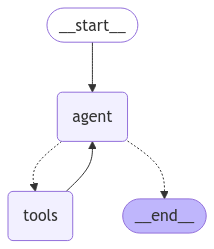

In [ ]:
## we use meta-llama-70b provided via Bedrock in this section

import json
from typing import Optional, TypedDict
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain.tools.render import render_text_description
from kai.llm_interfacing.model_provider import ChatBedrock

def _print_state(state: MessagesState):
    print("..."*15)
    for idx, message in enumerate(state["messages"]):
        print(f"{idx}: {message.content.splitlines()[0] if message.content else message.content}")
    print("..."*15)

@tool
def get_temperature(city: Annotated[str, "Name of the city"]):
    """Returns current temperature in given city"""
    return f"Current temperature in {city} is 80 degrees."

# define the tool node
tool_node = ToolNode(tools=[get_temperature])

# define the model provider
model_provider = ChatBedrock(
    model="us.meta.llama3-3-70b-instruct-v1:0"
)

def extract_json_from_text(text):
    """Extracts JSON code block from a multiline string."""
    pattern = r"```(json)?\s*(\{.*?\})\s*```"
    match = re.search(pattern, text, re.DOTALL)

    if match:
        json_str = match.group(2)
        try:
            return json.loads(json_str)  # Convert to Python dict
        except json.JSONDecodeError:
            return None  # Invalid JSON format

    return None

# define the agent
def agent_call(state: MessagesState):
    sys_msg = f"""You are an intelligent assistant who can help users with their weather related queries. 
You may not know answers to all questions as some of the answers may depend on real time weather data. However, you are given tools you can use to access that data.
Here is the schema of tools you are given:

{render_text_description([get_temperature])}

If you do need to call a tool, respond with a JSON object containing only two keys - tool_name and args. `tool_name` should be the name of the tool to call and `args` should be nested JSON containing the arguments to pass to the function in key value format.
Make sure you always use ``` at the start and end of the JSON block to clearly separate it from text.
If you have reached the answer, respond with text and add string 'FINAL ANSWER' to the beginning.
"""
    if "messages" not in state or not state["messages"] or \
        not isinstance(state["messages"][0], SystemMessage):
        state["messages"].insert(0, SystemMessage(content=sys_msg))
    if isinstance(state["messages"][-1], ToolMessage):
        tool_output = state["messages"][-1]
        state["messages"][-1] = HumanMessage(
            content=f"The output of tool {tool_output.name} is - {tool_output.content}"
        )
    response = model_provider.invoke(state["messages"])
    if "tool_name" in response.content:
        agent_response = extract_json_from_text(response.content)
        if not agent_response:
            return { "messages": [AIMessage(content="RETRY")] }
        response = AIMessage(
            content="",
            tool_calls=[{
                "name": agent_response.get("tool_name"),
                "args": agent_response.get("args"),
                "type": "tool_call",
                "id": "tool_call_id_1",
            }],
        )
    return { "messages": [response] }

# this is the conditional edge to parse and
# route the llm response to a tool
def should_call_tool(state: MessagesState):
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    if not last_message.content or "RETRY" in last_message.content:
        return "agent"
    return END
    
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent_call)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_call_tool, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
    

In [180]:
for chunk in app.stream(
    {"messages": [("human", "what's the weather in New York?")]}, stream_mode="values"
):
    print(chunk["messages"][-1].pretty_repr())

================================ Human Message =================================

what's the weather in New York?
================================== Ai Message ==================================
Tool Calls:
  get_temperature (tool_call_id_1)
 Call ID: tool_call_id_1
  Args:
    city: New York
================================= Tool Message =================================
Name: get_temperature

Current temperature in New York is 80 degrees.


ValueError: Got unknown type content='Current temperature in New York is 80 degrees.' name='get_temperature' id='e9e1a4e4-e60e-496b-b736-8afb0b8dac79' tool_call_id='tool_call_id_1'